In [34]:
# Calculate O diffusion from fcc to hcp hollow site on Pt(111)
from ase.build import fcc111, add_adsorbate
from ase.constraints import FixAtoms
from ase.calculators.emt import EMT
from ase.optimize import QuasiNewton
from ase.visualize import view

# 2x2-Pt(111) surface with 3 layers and an
# O atom adsorbed in a fcc-hollow site:
slab = fcc111('Pt', size=(4, 4, 4))
slab.center(axis=2, vacuum=4.0)
add_adsorbate(slab, 'O', 1.25, 'fcc')

# Fix second and third layers:
mask = [atom.tag > 1 for atom in slab]
#print(mask)
slab.set_constraint(FixAtoms(mask=mask))
# Use EMT potential:
slab.set_calculator(EMT())

# Initial state:
qn = QuasiNewton(slab, trajectory='initial.traj')
qn.run(fmax=0.01)
view(slab)
print(slab)



                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 12:30:16       11.762135*       7.9142
BFGSLineSearch:    1[  1] 12:30:16       10.214278*       1.0067
BFGSLineSearch:    2[  2] 12:30:16       10.068021*       0.4397
BFGSLineSearch:    3[  3] 12:30:16       10.025537*       0.1694
BFGSLineSearch:    4[  5] 12:30:16       10.013598*       0.0485
BFGSLineSearch:    5[  6] 12:30:16       10.012578*       0.0052
Atoms(symbols='OPt64', pbc=[True, True, False], cell=[[11.087434329005065, 0.0, 0.0], [5.5437171645025325, 9.601999791710057, 0.0], [0.0, 0.0, 14.78963916567]], tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]), calculator=EMT(...))


In [37]:
# 2x2-Pt(111) surface with 3 layers and an
# O atom adsorbed in a hcp-hollow site:
slab = fcc111('Pt', size=(4, 4, 4))
slab.center(axis=2, vacuum=4.0)
add_adsorbate(slab, 'O', 1.25, position=(10,6))


# Fix second and third layers:
mask = [atom.tag > 1 for atom in slab]
#print(mask)
slab.set_constraint(FixAtoms(mask=mask))
# Use EMT potential:
slab.set_calculator(EMT())

# Initial state:
qn = QuasiNewton(slab, trajectory='final.traj')
qn.run(fmax=0.01)
view(slab)
print(slab)

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 12:30:51       12.931905*      13.8177
BFGSLineSearch:    1[  1] 12:30:51       10.374012*       1.9868
BFGSLineSearch:    2[  2] 12:30:51       10.123256*       0.6328
BFGSLineSearch:    3[  3] 12:30:51       10.060169*       0.2316
BFGSLineSearch:    4[  4] 12:30:51       10.040064*       0.1340
BFGSLineSearch:    5[  5] 12:30:51       10.034029*       0.1065
BFGSLineSearch:    6[  6] 12:30:51       10.032282*       0.0932
BFGSLineSearch:    7[  8] 12:30:51       10.029925*       0.1004
BFGSLineSearch:    8[ 11] 12:30:51       10.020775*       0.0896
BFGSLineSearch:    9[ 13] 12:30:51       10.017212*       0.0879
BFGSLineSearch:   10[ 15] 12:30:52       10.014909*       0.0400
BFGSLineSearch:   11[ 16] 12:30:52       10.014429*       0.0557
BFGSLineSearch:   12[ 17] 12:30:52       10.013993*       0.0446
BFGSLineSearch:   13[ 19] 12:30:52       

In [38]:
from ase.io import read
from ase.constraints import FixAtoms
from ase.calculators.emt import EMT
from ase.neb import NEB
from ase.optimize import BFGS

initial = read('initial.traj')
final = read('final.traj')

constraint = FixAtoms(mask=[atom.tag > 1 for atom in initial])

images = [initial]
for i in range(9):
    image = initial.copy()
    image.set_calculator(EMT())
    image.set_constraint(constraint)
    images.append(image)

images.append(final)

neb = NEB(images)
neb.interpolate()
qn = BFGS(neb, trajectory='neb.traj')
qn.run(fmax=0.01)

      Step     Time          Energy         fmax
BFGS:    0 12:31:13       11.952573       13.5480
BFGS:    1 12:31:14       10.341315        2.7738
BFGS:    2 12:31:15       10.262182        1.5808
BFGS:    3 12:31:16       10.222886        1.0025
BFGS:    4 12:31:17       10.210267        0.9198
BFGS:    5 12:31:17       10.168778        0.2810
BFGS:    6 12:31:18       10.165129        0.2286
BFGS:    7 12:31:19       10.163920        0.1175
BFGS:    8 12:31:20       10.163112        0.0757
BFGS:    9 12:31:21       10.162314        0.0838
BFGS:   10 12:31:21       10.161827        0.0826
BFGS:   11 12:31:22       10.161634        0.0658
BFGS:   12 12:31:23       10.161567        0.0314
BFGS:   13 12:31:24       10.161544        0.0140
BFGS:   14 12:31:25       10.161530        0.0185
BFGS:   15 12:31:26       10.161503        0.0283
BFGS:   16 12:31:26       10.161466        0.0238
BFGS:   17 12:31:27       10.161439        0.0100


True

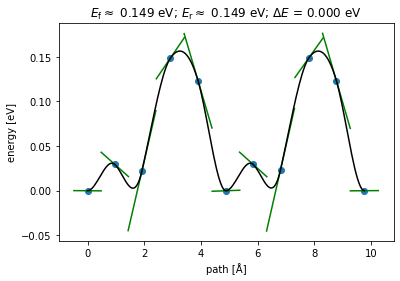

In [43]:
import matplotlib.pyplot as plt
from ase.neb import NEBTools
from ase.io import read

images = read('neb.traj@-11:')

nebtools = NEBTools(images)

# Get the calculated barrier and the energy change of the reaction.
Ef, dE = nebtools.get_barrier()

# Get the barrier without any interpolation between highest images.
Ef, dE = nebtools.get_barrier(fit=False)

# Get the actual maximum force at this point in the simulation.
max_force = nebtools.get_fmax()

# Create a figure like that coming from ASE-GUI.
fig = nebtools.plot_band()
fig.savefig('diffusion-barrier.png')
# To view movie with ase gui $ase gui neb.traj@-5:
# Then use NEB tools

view(images)

In [12]:
view(images)

In [44]:
# 2x2-Pt(111) surface with 3 layers and an
# O atom adsorbed in a fcc-hollow site:
slab = fcc111('Pt', size=(4, 4, 4))
slab.center(axis=2, vacuum=4.0)
add_adsorbate(slab, 'O', 1.25, 'fcc')
add_adsorbate(slab, 'O', 3.25, 'fcc')

# Fix second and third layers:
mask = [atom.tag > 1 for atom in slab]
#print(mask)
slab.set_constraint(FixAtoms(mask=mask))
# Use EMT potential:
slab.set_calculator(EMT())

# Initial state:
qn = QuasiNewton(slab, trajectory='initial.traj')
qn.run(fmax=0.01)
view(slab)
print(slab)

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 12:33:35       14.212177*       9.9645
BFGSLineSearch:    1[  1] 12:33:35       12.084765*       4.4037
BFGSLineSearch:    2[  4] 12:33:35       10.608374*       0.7409
BFGSLineSearch:    3[  5] 12:33:35       10.562439*       0.8166
BFGSLineSearch:    4[  7] 12:33:35       10.540719*       0.3759
BFGSLineSearch:    5[  9] 12:33:35       10.515102*       0.1698
BFGSLineSearch:    6[ 10] 12:33:36       10.509931*       0.0660
BFGSLineSearch:    7[ 11] 12:33:36       10.508373*       0.0331
BFGSLineSearch:    8[ 12] 12:33:36       10.508134*       0.0202
BFGSLineSearch:    9[ 13] 12:33:36       10.508023*       0.0051
Atoms(symbols='O2Pt64', pbc=[True, True, False], cell=[[11.087434329005065, 0.0, 0.0], [5.5437171645025325, 9.601999791710057, 0.0], [0.0, 0.0, 14.78963916567]], tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1

In [45]:
# 2x2-Pt(111) surface with 3 layers and an
# O atom adsorbed in a hcp-hollow site:
slab = fcc111('Pt', size=(4, 4, 4))
slab.center(axis=2, vacuum=4.0)
add_adsorbate(slab, 'O', 1.25, position=(10,6))
add_adsorbate(slab, 'O', 1.25, 'fcc')



# Fix second and third layers:
mask = [atom.tag > 1 for atom in slab]
#print(mask)
slab.set_constraint(FixAtoms(mask=mask))
# Use EMT potential:
slab.set_calculator(EMT())

# Initial state:
qn = QuasiNewton(slab, trajectory='final.traj')
qn.run(fmax=0.01)
view(slab)
print(slab)

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 12:34:13       14.389340*      13.8178
BFGSLineSearch:    1[  1] 12:34:13       10.668099*       3.3870
BFGSLineSearch:    2[  2] 12:34:13       10.276697*       2.3372
BFGSLineSearch:    3[  3] 12:34:13        9.988974*       0.4510
BFGSLineSearch:    4[  4] 12:34:13        9.943047*       0.1645
BFGSLineSearch:    5[  5] 12:34:14        9.928651*       0.1035
BFGSLineSearch:    6[  6] 12:34:14        9.926419*       0.0953
BFGSLineSearch:    7[  8] 12:34:14        9.924158*       0.0938
BFGSLineSearch:    8[ 10] 12:34:14        9.917130*       0.0998
BFGSLineSearch:    9[ 11] 12:34:14        9.913076*       0.1193
BFGSLineSearch:   10[ 13] 12:34:14        9.910037*       0.0626
BFGSLineSearch:   11[ 15] 12:34:14        9.908081*       0.0561
BFGSLineSearch:   12[ 17] 12:34:14        9.907226*       0.0372
BFGSLineSearch:   13[ 18] 12:34:14       

In [50]:
initial = read('initial.traj')
final = read('final.traj')

constraint = FixAtoms(mask=[atom.tag > 1 for atom in initial])

images = [initial]
for i in range(9):
    image = initial.copy()
    image.set_calculator(EMT())
    image.set_constraint(constraint)
    images.append(image)

images.append(final)

neb = NEB(images)
neb.interpolate()
qn = BFGS(neb, trajectory='neb.traj')
qn.run(fmax=0.1)

      Step     Time          Energy         fmax
BFGS:    0 12:46:52       12.716848        9.7999
BFGS:    1 12:46:53       12.406167        2.9882
BFGS:    2 12:46:54       12.180443        2.9823
BFGS:    3 12:46:55       11.539026        3.4447
BFGS:    4 12:46:56       11.018999        5.1269
BFGS:    5 12:46:56       10.681450        2.3314
BFGS:    6 12:46:57       10.532439        1.5059
BFGS:    7 12:46:58       10.514490        1.2478
BFGS:    8 12:46:59       10.484727        0.8750
BFGS:    9 12:47:00       10.484913        0.6399
BFGS:   10 12:47:01       10.478729        0.7405
BFGS:   11 12:47:02       10.477112        0.5817
BFGS:   12 12:47:02       10.476981        0.4866
BFGS:   13 12:47:03       10.474309        0.4723
BFGS:   14 12:47:04       10.472683        0.4242
BFGS:   15 12:47:05       10.472859        0.3408
BFGS:   16 12:47:06       10.472049        0.2736
BFGS:   17 12:47:07       10.470418        0.2495
BFGS:   18 12:47:07       10.469390        0.2718
B

True

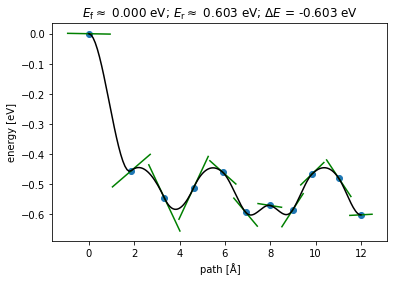

In [57]:
images = read('neb.traj@-11:')

nebtools = NEBTools(images)

# Get the calculated barrier and the energy change of the reaction.
Ef, dE = nebtools.get_barrier()

# Get the barrier without any interpolation between highest images.
Ef, dE = nebtools.get_barrier(fit=False)

# Get the actual maximum force at this point in the simulation.
max_force = nebtools.get_fmax()

# Create a figure like that coming from ASE-GUI.
fig = nebtools.plot_band()
fig.savefig('diffusion-barrier.png')
# To view movie with ase gui $ase gui neb.traj@-5:
# Then use NEB tools

view(images)

In [92]:
from ase.lattice.cubic import FaceCenteredCubic
from ase.md.langevin import Langevin
from ase.io.trajectory import Trajectory
from ase import units

#from asap3 import EMT  # Way too slow with ase.EMT !
size = 2

T = 300  # Kelvin

# Set up a crystal
slab = fcc111('Pt', size=(4, 4, 4))
slab.center(axis=2, vacuum=4.0)
add_adsorbate(slab, 'O', 1.25, 'fcc')
add_adsorbate(slab, 'O', 2.45, 'fcc')

# Fix second and third layers:
#mask = [atom.tag > 1 for atom in slab]
#print(mask)
#slab.set_constraint(FixAtoms(mask=mask))
# Use EMT potential:
slab.set_calculator(EMT())





# We want to run MD with constant energy using the Langevin algorithm
# with a time step of 5 fs, the temperature T and the friction
# coefficient to 0.02 atomic units.
dyn = Langevin(slab, 5 * units.fs, T * units.kB, 0.002)


def printenergy(a=slab):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))


dyn.attach(printenergy, interval=1)

# We also want to save the positions of all atoms after every 100th time step.
traj = Trajectory('moldyn3.traj', 'w', slab)
dyn.attach(traj.write, interval=1)

# Now run the dynamics
printenergy()
dyn.run(1000)

Energy per atom: Epot = 0.194eV  Ekin = 0.000eV (T=  0K)  Etot = 0.194eV
Energy per atom: Epot = 0.194eV  Ekin = 0.000eV (T=  0K)  Etot = 0.194eV
Energy per atom: Epot = 0.189eV  Ekin = 0.005eV (T= 36K)  Etot = 0.194eV
Energy per atom: Epot = 0.180eV  Ekin = 0.014eV (T=107K)  Etot = 0.194eV
Energy per atom: Epot = 0.171eV  Ekin = 0.023eV (T=175K)  Etot = 0.194eV
Energy per atom: Epot = 0.163eV  Ekin = 0.030eV (T=231K)  Etot = 0.193eV
Energy per atom: Epot = 0.160eV  Ekin = 0.033eV (T=255K)  Etot = 0.193eV
Energy per atom: Epot = 0.161eV  Ekin = 0.033eV (T=256K)  Etot = 0.194eV
Energy per atom: Epot = 0.162eV  Ekin = 0.032eV (T=247K)  Etot = 0.194eV
Energy per atom: Epot = 0.162eV  Ekin = 0.033eV (T=252K)  Etot = 0.194eV
Energy per atom: Epot = 0.161eV  Ekin = 0.033eV (T=255K)  Etot = 0.194eV
Energy per atom: Epot = 0.165eV  Ekin = 0.030eV (T=232K)  Etot = 0.195eV
Energy per atom: Epot = 0.163eV  Ekin = 0.031eV (T=240K)  Etot = 0.194eV
Energy per atom: Epot = 0.163eV  Ekin = 0.032eV (T=

Energy per atom: Epot = 0.169eV  Ekin = 0.027eV (T=207K)  Etot = 0.195eV
Energy per atom: Epot = 0.167eV  Ekin = 0.028eV (T=220K)  Etot = 0.195eV
Energy per atom: Epot = 0.166eV  Ekin = 0.029eV (T=225K)  Etot = 0.195eV
Energy per atom: Epot = 0.169eV  Ekin = 0.027eV (T=212K)  Etot = 0.196eV
Energy per atom: Epot = 0.166eV  Ekin = 0.029eV (T=224K)  Etot = 0.195eV
Energy per atom: Epot = 0.167eV  Ekin = 0.028eV (T=217K)  Etot = 0.195eV
Energy per atom: Epot = 0.170eV  Ekin = 0.026eV (T=200K)  Etot = 0.196eV
Energy per atom: Epot = 0.168eV  Ekin = 0.027eV (T=206K)  Etot = 0.195eV
Energy per atom: Epot = 0.168eV  Ekin = 0.026eV (T=204K)  Etot = 0.195eV
Energy per atom: Epot = 0.172eV  Ekin = 0.023eV (T=182K)  Etot = 0.195eV
Energy per atom: Epot = 0.170eV  Ekin = 0.025eV (T=191K)  Etot = 0.195eV
Energy per atom: Epot = 0.171eV  Ekin = 0.023eV (T=182K)  Etot = 0.195eV
Energy per atom: Epot = 0.174eV  Ekin = 0.022eV (T=167K)  Etot = 0.195eV
Energy per atom: Epot = 0.172eV  Ekin = 0.023eV (T=

Energy per atom: Epot = 0.172eV  Ekin = 0.028eV (T=219K)  Etot = 0.201eV
Energy per atom: Epot = 0.171eV  Ekin = 0.029eV (T=225K)  Etot = 0.200eV
Energy per atom: Epot = 0.174eV  Ekin = 0.027eV (T=211K)  Etot = 0.201eV
Energy per atom: Epot = 0.173eV  Ekin = 0.028eV (T=214K)  Etot = 0.201eV
Energy per atom: Epot = 0.172eV  Ekin = 0.028eV (T=217K)  Etot = 0.200eV
Energy per atom: Epot = 0.174eV  Ekin = 0.027eV (T=205K)  Etot = 0.201eV
Energy per atom: Epot = 0.174eV  Ekin = 0.027eV (T=208K)  Etot = 0.201eV
Energy per atom: Epot = 0.172eV  Ekin = 0.028eV (T=217K)  Etot = 0.200eV
Energy per atom: Epot = 0.174eV  Ekin = 0.027eV (T=206K)  Etot = 0.200eV
Energy per atom: Epot = 0.172eV  Ekin = 0.027eV (T=211K)  Etot = 0.200eV
Energy per atom: Epot = 0.171eV  Ekin = 0.028eV (T=220K)  Etot = 0.200eV
Energy per atom: Epot = 0.172eV  Ekin = 0.027eV (T=211K)  Etot = 0.200eV
Energy per atom: Epot = 0.172eV  Ekin = 0.028eV (T=218K)  Etot = 0.200eV
Energy per atom: Epot = 0.170eV  Ekin = 0.030eV (T=

Energy per atom: Epot = 0.177eV  Ekin = 0.022eV (T=167K)  Etot = 0.199eV
Energy per atom: Epot = 0.176eV  Ekin = 0.022eV (T=173K)  Etot = 0.199eV
Energy per atom: Epot = 0.178eV  Ekin = 0.021eV (T=163K)  Etot = 0.199eV
Energy per atom: Epot = 0.178eV  Ekin = 0.021eV (T=162K)  Etot = 0.199eV
Energy per atom: Epot = 0.177eV  Ekin = 0.022eV (T=167K)  Etot = 0.198eV
Energy per atom: Epot = 0.178eV  Ekin = 0.021eV (T=161K)  Etot = 0.199eV
Energy per atom: Epot = 0.178eV  Ekin = 0.021eV (T=162K)  Etot = 0.199eV
Energy per atom: Epot = 0.176eV  Ekin = 0.022eV (T=169K)  Etot = 0.198eV
Energy per atom: Epot = 0.177eV  Ekin = 0.021eV (T=165K)  Etot = 0.198eV
Energy per atom: Epot = 0.176eV  Ekin = 0.022eV (T=173K)  Etot = 0.199eV
Energy per atom: Epot = 0.175eV  Ekin = 0.023eV (T=181K)  Etot = 0.198eV
Energy per atom: Epot = 0.176eV  Ekin = 0.023eV (T=178K)  Etot = 0.199eV
Energy per atom: Epot = 0.175eV  Ekin = 0.024eV (T=186K)  Etot = 0.199eV
Energy per atom: Epot = 0.174eV  Ekin = 0.025eV (T=

Energy per atom: Epot = 0.176eV  Ekin = 0.027eV (T=206K)  Etot = 0.202eV
Energy per atom: Epot = 0.177eV  Ekin = 0.026eV (T=201K)  Etot = 0.203eV
Energy per atom: Epot = 0.176eV  Ekin = 0.026eV (T=204K)  Etot = 0.203eV
Energy per atom: Epot = 0.176eV  Ekin = 0.027eV (T=210K)  Etot = 0.203eV
Energy per atom: Epot = 0.177eV  Ekin = 0.026eV (T=205K)  Etot = 0.203eV
Energy per atom: Epot = 0.176eV  Ekin = 0.027eV (T=207K)  Etot = 0.203eV
Energy per atom: Epot = 0.175eV  Ekin = 0.027eV (T=212K)  Etot = 0.203eV
Energy per atom: Epot = 0.177eV  Ekin = 0.026eV (T=204K)  Etot = 0.203eV
Energy per atom: Epot = 0.176eV  Ekin = 0.026eV (T=204K)  Etot = 0.203eV
Energy per atom: Epot = 0.176eV  Ekin = 0.027eV (T=208K)  Etot = 0.203eV
Energy per atom: Epot = 0.177eV  Ekin = 0.026eV (T=199K)  Etot = 0.203eV
Energy per atom: Epot = 0.177eV  Ekin = 0.026eV (T=200K)  Etot = 0.203eV
Energy per atom: Epot = 0.176eV  Ekin = 0.026eV (T=205K)  Etot = 0.203eV
Energy per atom: Epot = 0.178eV  Ekin = 0.025eV (T=

Energy per atom: Epot = 0.180eV  Ekin = 0.026eV (T=201K)  Etot = 0.206eV
Energy per atom: Epot = 0.180eV  Ekin = 0.026eV (T=201K)  Etot = 0.206eV
Energy per atom: Epot = 0.179eV  Ekin = 0.026eV (T=205K)  Etot = 0.205eV
Energy per atom: Epot = 0.181eV  Ekin = 0.025eV (T=194K)  Etot = 0.206eV
Energy per atom: Epot = 0.181eV  Ekin = 0.025eV (T=193K)  Etot = 0.206eV
Energy per atom: Epot = 0.180eV  Ekin = 0.026eV (T=199K)  Etot = 0.205eV
Energy per atom: Epot = 0.181eV  Ekin = 0.024eV (T=189K)  Etot = 0.206eV
Energy per atom: Epot = 0.181eV  Ekin = 0.024eV (T=189K)  Etot = 0.206eV
Energy per atom: Epot = 0.180eV  Ekin = 0.025eV (T=193K)  Etot = 0.205eV
Energy per atom: Epot = 0.182eV  Ekin = 0.023eV (T=180K)  Etot = 0.205eV
Energy per atom: Epot = 0.182eV  Ekin = 0.023eV (T=181K)  Etot = 0.205eV
Energy per atom: Epot = 0.180eV  Ekin = 0.025eV (T=190K)  Etot = 0.205eV
Energy per atom: Epot = 0.182eV  Ekin = 0.024eV (T=182K)  Etot = 0.205eV
Energy per atom: Epot = 0.181eV  Ekin = 0.024eV (T=

Energy per atom: Epot = 0.184eV  Ekin = 0.024eV (T=187K)  Etot = 0.208eV
Energy per atom: Epot = 0.183eV  Ekin = 0.025eV (T=194K)  Etot = 0.208eV
Energy per atom: Epot = 0.184eV  Ekin = 0.024eV (T=189K)  Etot = 0.209eV
Energy per atom: Epot = 0.184eV  Ekin = 0.024eV (T=186K)  Etot = 0.208eV
Energy per atom: Epot = 0.183eV  Ekin = 0.024eV (T=190K)  Etot = 0.208eV
Energy per atom: Epot = 0.184eV  Ekin = 0.024eV (T=188K)  Etot = 0.208eV
Energy per atom: Epot = 0.184eV  Ekin = 0.024eV (T=187K)  Etot = 0.208eV
Energy per atom: Epot = 0.182eV  Ekin = 0.026eV (T=198K)  Etot = 0.208eV
Energy per atom: Epot = 0.183eV  Ekin = 0.026eV (T=198K)  Etot = 0.208eV
Energy per atom: Epot = 0.183eV  Ekin = 0.026eV (T=200K)  Etot = 0.209eV
Energy per atom: Epot = 0.181eV  Ekin = 0.027eV (T=206K)  Etot = 0.208eV
Energy per atom: Epot = 0.182eV  Ekin = 0.026eV (T=201K)  Etot = 0.208eV
Energy per atom: Epot = 0.182eV  Ekin = 0.026eV (T=200K)  Etot = 0.208eV
Energy per atom: Epot = 0.181eV  Ekin = 0.026eV (T=

Energy per atom: Epot = 0.186eV  Ekin = 0.021eV (T=161K)  Etot = 0.207eV
Energy per atom: Epot = 0.186eV  Ekin = 0.021eV (T=164K)  Etot = 0.207eV
Energy per atom: Epot = 0.185eV  Ekin = 0.023eV (T=175K)  Etot = 0.207eV
Energy per atom: Epot = 0.185eV  Ekin = 0.022eV (T=173K)  Etot = 0.207eV
Energy per atom: Epot = 0.185eV  Ekin = 0.023eV (T=177K)  Etot = 0.207eV
Energy per atom: Epot = 0.183eV  Ekin = 0.024eV (T=186K)  Etot = 0.207eV
Energy per atom: Epot = 0.184eV  Ekin = 0.024eV (T=184K)  Etot = 0.208eV
Energy per atom: Epot = 0.183eV  Ekin = 0.024eV (T=188K)  Etot = 0.208eV
Energy per atom: Epot = 0.182eV  Ekin = 0.025eV (T=197K)  Etot = 0.207eV
Energy per atom: Epot = 0.182eV  Ekin = 0.025eV (T=193K)  Etot = 0.207eV
Energy per atom: Epot = 0.182eV  Ekin = 0.025eV (T=196K)  Etot = 0.207eV
Energy per atom: Epot = 0.181eV  Ekin = 0.026eV (T=202K)  Etot = 0.207eV
Energy per atom: Epot = 0.182eV  Ekin = 0.025eV (T=196K)  Etot = 0.207eV
Energy per atom: Epot = 0.182eV  Ekin = 0.026eV (T=

Energy per atom: Epot = 0.184eV  Ekin = 0.027eV (T=209K)  Etot = 0.211eV
Energy per atom: Epot = 0.183eV  Ekin = 0.028eV (T=217K)  Etot = 0.211eV
Energy per atom: Epot = 0.183eV  Ekin = 0.028eV (T=218K)  Etot = 0.211eV
Energy per atom: Epot = 0.183eV  Ekin = 0.028eV (T=219K)  Etot = 0.211eV
Energy per atom: Epot = 0.182eV  Ekin = 0.029eV (T=228K)  Etot = 0.211eV
Energy per atom: Epot = 0.183eV  Ekin = 0.029eV (T=223K)  Etot = 0.211eV
Energy per atom: Epot = 0.183eV  Ekin = 0.029eV (T=223K)  Etot = 0.212eV
Energy per atom: Epot = 0.182eV  Ekin = 0.029eV (T=226K)  Etot = 0.211eV
Energy per atom: Epot = 0.183eV  Ekin = 0.028eV (T=217K)  Etot = 0.211eV
Energy per atom: Epot = 0.183eV  Ekin = 0.028eV (T=214K)  Etot = 0.211eV
Energy per atom: Epot = 0.183eV  Ekin = 0.028eV (T=215K)  Etot = 0.211eV
Energy per atom: Epot = 0.184eV  Ekin = 0.027eV (T=206K)  Etot = 0.211eV
Energy per atom: Epot = 0.184eV  Ekin = 0.026eV (T=204K)  Etot = 0.211eV
Energy per atom: Epot = 0.184eV  Ekin = 0.027eV (T=

True

In [91]:
images = read('moldyn3.traj@-5')
view(images)

In [90]:
size = 2

T = 200  # Kelvin

# Set up a crystal
slab = fcc111('Pt', size=(4, 4, 4))
slab.center(axis=2, vacuum=4.0)
add_adsorbate(slab, 'O', 1.25, 'fcc')
add_adsorbate(slab, 'O', 2.45, 'fcc')
add_adsorbate(slab, 'C', 1.25, position=(10,6))
add_adsorbate(slab, 'O', 2.35, position=(10,6))

# Fix second and third layers:
#mask = [atom.tag > 1 for atom in slab]
#print(mask)
#slab.set_constraint(FixAtoms(mask=mask))
# Use EMT potential:
slab.set_calculator(EMT())





# We want to run MD with constant energy using the Langevin algorithm
# with a time step of 5 fs, the temperature T and the friction
# coefficient to 0.02 atomic units.
dyn = Langevin(slab, 5 * units.fs, T * units.kB, 0.002)


def printenergy(a=slab):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))


dyn.attach(printenergy, interval=1)

# We also want to save the positions of all atoms after every 100th time step.
traj = Trajectory('moldyn3.traj', 'w', slab)
dyn.attach(traj.write, interval=1)

# Now run the dynamics
printenergy()
dyn.run(1000)

Energy per atom: Epot = 0.207eV  Ekin = 0.000eV (T=  0K)  Etot = 0.207eV
Energy per atom: Epot = 0.207eV  Ekin = 0.000eV (T=  0K)  Etot = 0.207eV
Energy per atom: Epot = 0.199eV  Ekin = 0.007eV (T= 54K)  Etot = 0.206eV
Energy per atom: Epot = 0.184eV  Ekin = 0.021eV (T=164K)  Etot = 0.206eV
Energy per atom: Epot = 0.171eV  Ekin = 0.034eV (T=265K)  Etot = 0.205eV
Energy per atom: Epot = 0.162eV  Ekin = 0.044eV (T=337K)  Etot = 0.205eV
Energy per atom: Epot = 0.159eV  Ekin = 0.047eV (T=363K)  Etot = 0.205eV
Energy per atom: Epot = 0.160eV  Ekin = 0.045eV (T=350K)  Etot = 0.206eV
Energy per atom: Epot = 0.163eV  Ekin = 0.043eV (T=333K)  Etot = 0.206eV
Energy per atom: Epot = 0.162eV  Ekin = 0.043eV (T=334K)  Etot = 0.206eV
Energy per atom: Epot = 0.162eV  Ekin = 0.043eV (T=332K)  Etot = 0.205eV
Energy per atom: Epot = 0.168eV  Ekin = 0.038eV (T=293K)  Etot = 0.206eV
Energy per atom: Epot = 0.167eV  Ekin = 0.038eV (T=295K)  Etot = 0.205eV
Energy per atom: Epot = 0.166eV  Ekin = 0.038eV (T=

Energy per atom: Epot = 0.174eV  Ekin = 0.030eV (T=232K)  Etot = 0.204eV
Energy per atom: Epot = 0.173eV  Ekin = 0.031eV (T=237K)  Etot = 0.204eV
Energy per atom: Epot = 0.172eV  Ekin = 0.032eV (T=249K)  Etot = 0.204eV
Energy per atom: Epot = 0.174eV  Ekin = 0.030eV (T=235K)  Etot = 0.204eV
Energy per atom: Epot = 0.173eV  Ekin = 0.031eV (T=240K)  Etot = 0.204eV
Energy per atom: Epot = 0.171eV  Ekin = 0.033eV (T=254K)  Etot = 0.204eV
Energy per atom: Epot = 0.173eV  Ekin = 0.031eV (T=239K)  Etot = 0.204eV
Energy per atom: Epot = 0.173eV  Ekin = 0.031eV (T=240K)  Etot = 0.204eV
Energy per atom: Epot = 0.172eV  Ekin = 0.032eV (T=246K)  Etot = 0.204eV
Energy per atom: Epot = 0.176eV  Ekin = 0.029eV (T=227K)  Etot = 0.205eV
Energy per atom: Epot = 0.175eV  Ekin = 0.029eV (T=225K)  Etot = 0.205eV
Energy per atom: Epot = 0.174eV  Ekin = 0.030eV (T=235K)  Etot = 0.204eV
Energy per atom: Epot = 0.177eV  Ekin = 0.028eV (T=217K)  Etot = 0.205eV
Energy per atom: Epot = 0.177eV  Ekin = 0.027eV (T=

Energy per atom: Epot = 0.174eV  Ekin = 0.026eV (T=205K)  Etot = 0.200eV
Energy per atom: Epot = 0.177eV  Ekin = 0.024eV (T=185K)  Etot = 0.201eV
Energy per atom: Epot = 0.176eV  Ekin = 0.024eV (T=188K)  Etot = 0.201eV
Energy per atom: Epot = 0.174eV  Ekin = 0.026eV (T=201K)  Etot = 0.200eV
Energy per atom: Epot = 0.177eV  Ekin = 0.024eV (T=186K)  Etot = 0.201eV
Energy per atom: Epot = 0.177eV  Ekin = 0.024eV (T=188K)  Etot = 0.201eV
Energy per atom: Epot = 0.174eV  Ekin = 0.026eV (T=204K)  Etot = 0.200eV
Energy per atom: Epot = 0.177eV  Ekin = 0.024eV (T=186K)  Etot = 0.201eV
Energy per atom: Epot = 0.176eV  Ekin = 0.024eV (T=189K)  Etot = 0.201eV
Energy per atom: Epot = 0.174eV  Ekin = 0.026eV (T=203K)  Etot = 0.200eV
Energy per atom: Epot = 0.176eV  Ekin = 0.024eV (T=189K)  Etot = 0.201eV
Energy per atom: Epot = 0.176eV  Ekin = 0.025eV (T=192K)  Etot = 0.201eV
Energy per atom: Epot = 0.173eV  Ekin = 0.027eV (T=206K)  Etot = 0.199eV
Energy per atom: Epot = 0.176eV  Ekin = 0.024eV (T=

Energy per atom: Epot = 0.178eV  Ekin = 0.022eV (T=169K)  Etot = 0.199eV
Energy per atom: Epot = 0.179eV  Ekin = 0.021eV (T=161K)  Etot = 0.200eV
Energy per atom: Epot = 0.181eV  Ekin = 0.020eV (T=153K)  Etot = 0.200eV
Energy per atom: Epot = 0.178eV  Ekin = 0.021eV (T=165K)  Etot = 0.200eV
Energy per atom: Epot = 0.179eV  Ekin = 0.021eV (T=159K)  Etot = 0.200eV
Energy per atom: Epot = 0.181eV  Ekin = 0.019eV (T=149K)  Etot = 0.200eV
Energy per atom: Epot = 0.178eV  Ekin = 0.022eV (T=168K)  Etot = 0.200eV
Energy per atom: Epot = 0.180eV  Ekin = 0.020eV (T=156K)  Etot = 0.200eV
Energy per atom: Epot = 0.181eV  Ekin = 0.020eV (T=152K)  Etot = 0.200eV
Energy per atom: Epot = 0.178eV  Ekin = 0.022eV (T=167K)  Etot = 0.200eV
Energy per atom: Epot = 0.179eV  Ekin = 0.021eV (T=163K)  Etot = 0.200eV
Energy per atom: Epot = 0.180eV  Ekin = 0.020eV (T=157K)  Etot = 0.201eV
Energy per atom: Epot = 0.177eV  Ekin = 0.022eV (T=173K)  Etot = 0.200eV
Energy per atom: Epot = 0.179eV  Ekin = 0.021eV (T=

Energy per atom: Epot = 0.178eV  Ekin = 0.021eV (T=162K)  Etot = 0.199eV
Energy per atom: Epot = 0.177eV  Ekin = 0.022eV (T=171K)  Etot = 0.199eV
Energy per atom: Epot = 0.178eV  Ekin = 0.021eV (T=166K)  Etot = 0.199eV
Energy per atom: Epot = 0.177eV  Ekin = 0.022eV (T=171K)  Etot = 0.199eV
Energy per atom: Epot = 0.176eV  Ekin = 0.023eV (T=175K)  Etot = 0.199eV
Energy per atom: Epot = 0.177eV  Ekin = 0.022eV (T=168K)  Etot = 0.199eV
Energy per atom: Epot = 0.177eV  Ekin = 0.022eV (T=172K)  Etot = 0.199eV
Energy per atom: Epot = 0.176eV  Ekin = 0.023eV (T=178K)  Etot = 0.199eV
Energy per atom: Epot = 0.177eV  Ekin = 0.022eV (T=172K)  Etot = 0.199eV
Energy per atom: Epot = 0.177eV  Ekin = 0.022eV (T=174K)  Etot = 0.199eV
Energy per atom: Epot = 0.176eV  Ekin = 0.022eV (T=172K)  Etot = 0.199eV
Energy per atom: Epot = 0.178eV  Ekin = 0.021eV (T=163K)  Etot = 0.199eV
Energy per atom: Epot = 0.178eV  Ekin = 0.021eV (T=160K)  Etot = 0.199eV
Energy per atom: Epot = 0.177eV  Ekin = 0.021eV (T=

Energy per atom: Epot = 0.177eV  Ekin = 0.021eV (T=160K)  Etot = 0.198eV
Energy per atom: Epot = 0.176eV  Ekin = 0.022eV (T=169K)  Etot = 0.198eV
Energy per atom: Epot = 0.177eV  Ekin = 0.021eV (T=160K)  Etot = 0.198eV
Energy per atom: Epot = 0.177eV  Ekin = 0.021eV (T=162K)  Etot = 0.198eV
Energy per atom: Epot = 0.176eV  Ekin = 0.022eV (T=169K)  Etot = 0.198eV
Energy per atom: Epot = 0.178eV  Ekin = 0.020eV (T=157K)  Etot = 0.198eV
Energy per atom: Epot = 0.177eV  Ekin = 0.021eV (T=159K)  Etot = 0.198eV
Energy per atom: Epot = 0.176eV  Ekin = 0.022eV (T=167K)  Etot = 0.198eV
Energy per atom: Epot = 0.178eV  Ekin = 0.020eV (T=156K)  Etot = 0.198eV
Energy per atom: Epot = 0.178eV  Ekin = 0.020eV (T=157K)  Etot = 0.198eV
Energy per atom: Epot = 0.177eV  Ekin = 0.021eV (T=160K)  Etot = 0.198eV
Energy per atom: Epot = 0.179eV  Ekin = 0.019eV (T=147K)  Etot = 0.198eV
Energy per atom: Epot = 0.179eV  Ekin = 0.019eV (T=148K)  Etot = 0.198eV
Energy per atom: Epot = 0.178eV  Ekin = 0.020eV (T=

Energy per atom: Epot = 0.181eV  Ekin = 0.018eV (T=143K)  Etot = 0.199eV
Energy per atom: Epot = 0.181eV  Ekin = 0.018eV (T=140K)  Etot = 0.199eV
Energy per atom: Epot = 0.182eV  Ekin = 0.018eV (T=136K)  Etot = 0.200eV
Energy per atom: Epot = 0.181eV  Ekin = 0.019eV (T=145K)  Etot = 0.199eV
Energy per atom: Epot = 0.182eV  Ekin = 0.018eV (T=141K)  Etot = 0.200eV
Energy per atom: Epot = 0.182eV  Ekin = 0.018eV (T=139K)  Etot = 0.200eV
Energy per atom: Epot = 0.180eV  Ekin = 0.019eV (T=150K)  Etot = 0.200eV
Energy per atom: Epot = 0.181eV  Ekin = 0.019eV (T=146K)  Etot = 0.200eV
Energy per atom: Epot = 0.182eV  Ekin = 0.019eV (T=145K)  Etot = 0.200eV
Energy per atom: Epot = 0.180eV  Ekin = 0.020eV (T=155K)  Etot = 0.200eV
Energy per atom: Epot = 0.181eV  Ekin = 0.019eV (T=151K)  Etot = 0.200eV
Energy per atom: Epot = 0.181eV  Ekin = 0.019eV (T=150K)  Etot = 0.201eV
Energy per atom: Epot = 0.180eV  Ekin = 0.021eV (T=160K)  Etot = 0.200eV
Energy per atom: Epot = 0.181eV  Ekin = 0.020eV (T=

Energy per atom: Epot = 0.187eV  Ekin = 0.019eV (T=148K)  Etot = 0.206eV
Energy per atom: Epot = 0.185eV  Ekin = 0.020eV (T=156K)  Etot = 0.205eV
Energy per atom: Epot = 0.186eV  Ekin = 0.020eV (T=154K)  Etot = 0.206eV
Energy per atom: Epot = 0.186eV  Ekin = 0.020eV (T=153K)  Etot = 0.206eV
Energy per atom: Epot = 0.185eV  Ekin = 0.021eV (T=159K)  Etot = 0.205eV
Energy per atom: Epot = 0.185eV  Ekin = 0.021eV (T=159K)  Etot = 0.205eV
Energy per atom: Epot = 0.185eV  Ekin = 0.020eV (T=158K)  Etot = 0.205eV
Energy per atom: Epot = 0.183eV  Ekin = 0.022eV (T=167K)  Etot = 0.205eV
Energy per atom: Epot = 0.184eV  Ekin = 0.021eV (T=165K)  Etot = 0.205eV
Energy per atom: Epot = 0.184eV  Ekin = 0.022eV (T=168K)  Etot = 0.205eV
Energy per atom: Epot = 0.183eV  Ekin = 0.023eV (T=176K)  Etot = 0.205eV
Energy per atom: Epot = 0.183eV  Ekin = 0.023eV (T=174K)  Etot = 0.205eV
Energy per atom: Epot = 0.183eV  Ekin = 0.022eV (T=172K)  Etot = 0.205eV
Energy per atom: Epot = 0.182eV  Ekin = 0.023eV (T=

True